In [1]:
import numpy as np
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import torch.optim as optim
import torch.nn as nn
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

# Define the dataset class
# Define the dataset class
class TrashDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.class_labels = ["glass", "paper",
                             "cardboard", "plastic", "metal", "trash"]
        self.data = []
        self.labels = []
        self.transform = transform

        # Load data and labels from the dataset folder
        for label in self.class_labels:
            class_path = os.path.join(self.dataset_path, label)
            for img_path in os.listdir(class_path):
                self.data.append(os.path.join(class_path, img_path))
                self.labels.append(self.class_labels.index(label))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        img = img.astype(np.uint8)  # Change the data type to uint8
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

# Create PyTorch datasets and data loaders
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_dataset = TrashDataset(
    "dataset-resized/dataset-resized", transform=train_transform)
test_dataset = TrashDataset(
    "dataset-resized/dataset-resized", transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(train_dataset))
val_size = int(0.15 * len(train_dataset))
remaining = len(train_dataset) - train_size - val_size
test_size = len(test_dataset)

train_dataset, val_dataset, remaining_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size, remaining])

# Select initial training data (e.g., 20% of the remaining training set)
initial_train_size = int(0.2 * len(remaining_dataset))
initial_train_dataset, unlabeled_train_dataset = torch.utils.data.random_split(
    remaining_dataset, [initial_train_size, len(remaining_dataset) - initial_train_size])

# Create a DataLoader for the initial training set and the unlabeled set
initial_train_loader = DataLoader(
    initial_train_dataset, batch_size=16, shuffle=True)
unlabeled_train_loader = DataLoader(
    unlabeled_train_dataset, batch_size=16, shuffle=False)

# Convert the datasets to tensors
X_train, y_train = zip(*initial_train_dataset)
X_train = torch.stack(X_train)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val, y_val = zip(*val_dataset)
X_val = torch.stack(X_val)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test, y_test = zip(*test_dataset)
X_test = torch.stack(X_test)
y_test = torch.tensor(y_test, dtype=torch.long)

In [2]:

# Define the ShuffleNet v2 model
model = models.shufflenet_v2_x1_0(pretrained=True)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model on the initial dataset
num_epochs = 10

# Wrap the model using Skorch
wrapped_model = NeuralNetClassifier(
    model,
    criterion=criterion,
    optimizer=optim.Adam,
    lr=0.001,
    batch_size=16,
    max_epochs=num_epochs,
    train_split=None,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Define train_model function


def train_model(model, train_loader, num_epochs, criterion, optimizer):
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()

        for inputs, labels in train_loader:
            inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
            labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    return model


# Train the model
model = train_model(model, initial_train_loader,
                    num_epochs, criterion, optimizer)

# Define the evaluation function


def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
            labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    return accuracy, y_true, y_pred



# Define a function to implement the query strategy


def uncertainty_sampling(predictions, num_samples):
    uncertainties = -np.max(predictions, axis=1)
    indices = np.argpartition(uncertainties, -num_samples)[-num_samples:]
    return indices

c:\Users\bnmhj\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\bnmhj\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 5.9575
Epoch 2/10, Loss: 1.2640
Epoch 3/10, Loss: 0.4841
Epoch 4/10, Loss: 0.4585
Epoch 5/10, Loss: 0.4166
Epoch 6/10, Loss: 0.4513
Epoch 7/10, Loss: 0.4249
Epoch 8/10, Loss: 0.1878
Epoch 9/10, Loss: 0.0994
Epoch 10/10, Loss: 0.1549


In [3]:

# Define the hyperparameter search space
param_grid = {
    'lr': [1e-4, 1e-3, 1e-2]
}

# Perform a grid search using Sklearn
grid = GridSearchCV(
    estimator=wrapped_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=[(np.arange(len(y_train)), np.arange(len(y_val)))],
    refit=True,
    verbose=3
)

# Fit the model
grid.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

# Get the best hyperparameters
best_params = grid.best_params_
print("Best hyperparameters:", best_params)


Fitting 1 folds for each of 3 candidates, totalling 3 fits
  epoch    train_loss     dur
-------  ------------  ------
      1        0.2565  5.4251
      2        0.0062  3.5904
      3        0.0029  4.1936
      4        0.0020  4.8355
      5        0.0016  3.5604
      6        0.0013  3.6715
      7        0.0011  4.3718
      8        0.0009  4.4382
      9        0.0008  4.3224
     10        0.0007  3.7199
[CV 1/1] END .........................lr=0.0001;, score=0.625 total time=  48.9s
  epoch    train_loss     dur
-------  ------------  ------
      1        0.3869  4.0159
      2        0.1088  3.7754
      3        0.0389  3.9510
      4        0.0086  4.1174
      5        0.0018  4.1738
      6        0.0016  4.3390
      7        0.0011  4.4731
      8        0.0007  4.6946
      9        0.0004  4.6967
     10        0.0003  4.3754
[CV 1/1] END ..........................lr=0.001;, score=0.636 total time=  52.0s
  epoch    train_loss     dur
-------  ------------  ------

In [4]:

# Evaluate the model on the test set
test_accuracy = grid.score(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Active Learning Loop
num_iterations = 5
num_samples_to_label = 10
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

for iteration in range(num_iterations):
    print(f'Iteration {iteration + 1}/{num_iterations}')

    # Make predictions on the unlabeled dataset
    model.eval()
    unlabeled_predictions = []

    with torch.no_grad():
        for inputs, _ in unlabeled_train_loader:
            inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            unlabeled_predictions.extend(probabilities)

    # Select the most uncertain samples
    selected_indices = uncertainty_sampling(
        unlabeled_predictions, num_samples_to_label)

    # Label the selected samples (simulate labeling)
    selected_samples = [unlabeled_train_dataset[i] for i in selected_indices]

    # Remove the selected samples from the unlabeled dataset and add them to the labeled dataset
    initial_train_dataset += selected_samples
    unlabeled_train_dataset = torch.utils.data.Subset(unlabeled_train_dataset, [
                                                      i for i in range(len(unlabeled_train_dataset)) if i not in selected_indices])

    # Update the DataLoaders
    initial_train_loader = DataLoader(
        initial_train_dataset, batch_size=16, shuffle=True)
    unlabeled_train_loader = DataLoader(
        unlabeled_train_dataset, batch_size=16, shuffle=False)

    # Retrain the model
    num_epochs = 5
    model = train_model(model, initial_train_loader,
                        num_epochs, criterion, optimizer)

    # Evaluate the model
    accuracy, _, _ = evaluate_model(model, val_loader)
    print(f'Validation Accuracy: {accuracy:.2f}%')


    # Check stopping criteria (you can also use other criteria such as a pre-defined accuracy threshold)
    if len(unlabeled_train_dataset) == 0:
        break

print('Active learning loop completed.')

# Evaluate the model on the test set
test_accuracy, y_true, y_pred = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 0.79%
Iteration 1/5
Epoch 1/5, Loss: 0.7606
Epoch 2/5, Loss: 0.1657
Epoch 3/5, Loss: 0.6487
Epoch 4/5, Loss: 0.2710
Epoch 5/5, Loss: 0.4112
Validation Accuracy: 45.91%
Iteration 2/5
Epoch 1/5, Loss: 0.4001
Epoch 2/5, Loss: 0.1818
Epoch 3/5, Loss: 0.0860
Epoch 4/5, Loss: 0.2025
Epoch 5/5, Loss: 0.2438
Validation Accuracy: 57.26%
Iteration 3/5
Epoch 1/5, Loss: 0.5364
Epoch 2/5, Loss: 0.1373
Epoch 3/5, Loss: 0.4289
Epoch 4/5, Loss: 0.3697
Epoch 5/5, Loss: 0.3218
Validation Accuracy: 57.78%
Iteration 4/5
Epoch 1/5, Loss: 0.4957
Epoch 2/5, Loss: 0.4298
Epoch 3/5, Loss: 0.2707
Epoch 4/5, Loss: 0.3998
Epoch 5/5, Loss: 0.3832
Validation Accuracy: 57.78%
Iteration 5/5
Epoch 1/5, Loss: 0.4634
Epoch 2/5, Loss: 0.3581
Epoch 3/5, Loss: 0.3523
Epoch 4/5, Loss: 0.1101
Epoch 5/5, Loss: 0.0700
Validation Accuracy: 60.95%
Active learning loop completed.
Test Accuracy: 66.76%


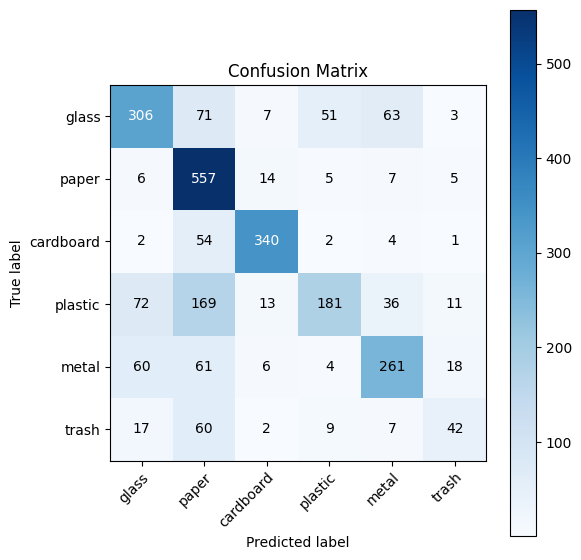

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, class_labels):
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_labels, yticklabels=class_labels,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm, train_dataset.dataset.class_labels)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

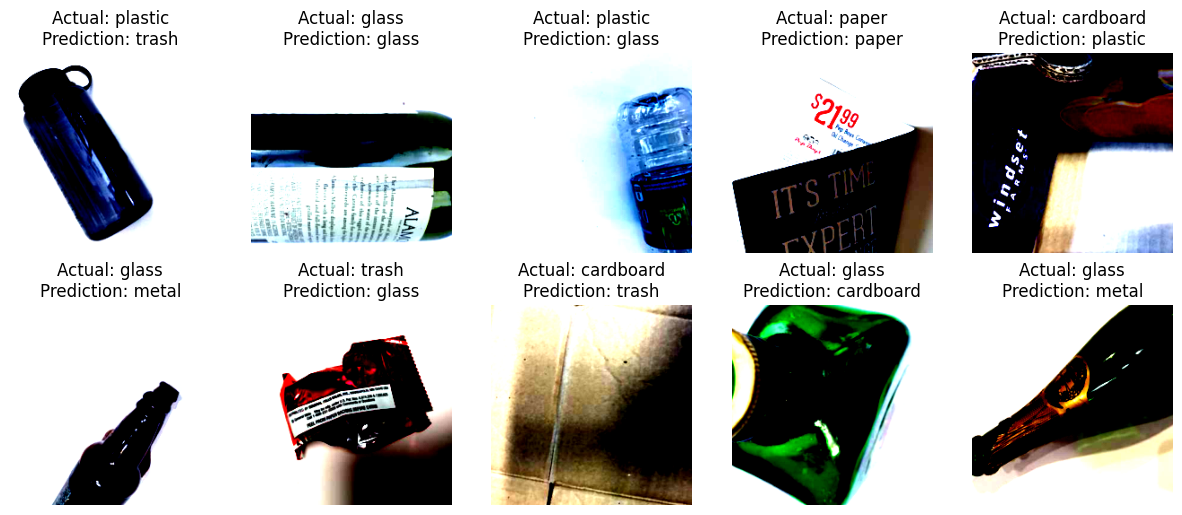

In [8]:
# make some predictions on the test set
model.eval()
predictions = []

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
        outputs = model(inputs)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
        predictions.extend(probabilities)

# select the most uncertain samples
selected_indices = uncertainty_sampling(predictions, 10)

# visualize the selected samples
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i, idx in enumerate(selected_indices):
    img = X_test[idx].numpy().transpose(1, 2, 0)
    actual_class = train_dataset.dataset.class_labels[y_test[idx]]
    predicted_class = train_dataset.dataset.class_labels[np.argmax(predictions[idx])]
    title = f'Actual: {actual_class}\nPrediction: {predicted_class}'
    ax[i // 5, i % 5].imshow(img)
    ax[i // 5, i % 5].set_title(title)
    ax[i // 5, i % 5].axis('off')


plt.show()